# EEP 153 Proj 3: Team F (Akinwumi Adesina)

# Food Demand in Nigeria

**Population of Interest**: Young population of Nigeria

**Topics & Goals**: Our project focused on understanding food demand in Nigeria and the relationship between Gross National Income (GNI) and nutritional value of the diet.

## Project Setup

In [1]:
!pip install -r requirements.txt
!pip install python-dateutil
!pip install fooddatacentral

In [2]:
from eep153_tools.sheets import read_sheets
import numpy as np
import pandas as pd

apikey = "lxD6lWLfAtFMmMogo98BZyZakAnjLIADqzEbiTjs" 

## [A] Choice of a population, with supporting expenditure data

In [ ]:
#load datset
consumption_ownprod = pd.read_excel('Nigeria LSMS Consumption from Own Production.xlsx')
consumption = pd.read_excel('Nigeria LSMS Consumption.xlsx')
expenditures = pd.read_excel('Nigeria LSMS.xlsx',sheet_name='Expenditures')
hh_characteristics = pd.read_excel('Nigeria LSMS.xlsx',sheet_name='HH Characteristics')
rdi = pd.read_excel('Uganda.xlsx',sheet_name='RDI')

In [ ]:
# Get expenditures...
expenditures.columns.name = 'j'

expenditures = expenditures.groupby('j',axis=1).sum()
expenditures = expenditures.replace(0,np.nan)
expenditures = np.log(expenditures.set_index(['i','t','m']))

expenditures.head()

In [ ]:
# Get HH characteristics...
hh_characteristics.columns.name = 'k'
hh_characteristics.set_index(['i','t','m'],inplace=True)

# Household with more than 3 kids
hh = hh_characteristics
hh['Youth'] = hh['M 00-03']+hh['M 04-08']+hh['F 00-03']+hh['F 04-08']
hh_young = hh[hh['Youth']>3]

hh_characteristics.head()

In [ ]:
#consumption
if 'm' not in consumption.columns:
    consumption['m'] = 1

consumption = consumption.set_index(['i','t','m','u'])
consumption.columns.name = 'k'

consumption = consumption.apply(lambda x: pd.to_numeric(x,errors='coerce'))
consumption = consumption.replace(0,np.nan)

consumption.head()

In [ ]:
#rdi
rdi = rdi.set_index('n')
rdi.columns.name = 'k'

rdi.head()

### Step 2: Estimate Demand System

Here, use data on log *expenditures* and household characteristics to create a CFEDemand `result`.

In [ ]:
def estimate_demand(expenditures,hh_characteristics):
    # Drop food that few people consume
    from cfe.estimation import drop_columns_wo_covariance
    
    expenditures1 = drop_columns_wo_covariance(expenditures,min_obs=30)
    
    use = expenditures1.index.intersection(hh_characteristics.index)
    expenditures1 = expenditures1.loc[use,:]
    hh_characteristics = hh_characteristics.loc[use,:]
    
    expenditures2 = expenditures1.stack()
    hh_characteristics1 = hh_characteristics.stack()

    assert expenditures2.index.names == ['i','t','m','j']
    assert hh_characteristics1.index.names == ['i','t','m','k']
    
    from cfe import Regression

    result = Regression(y=expenditures2,d=hh_characteristics1)
    
    return result,expenditures2

### Demand System for All Household

In [ ]:
result1, exp1 = estimate_demand(expenditures,hh_characteristics)

In [ ]:
result1.predicted_expenditures()

In [ ]:
%matplotlib notebook
import matplotlib.pyplot as plt
df = pd.DataFrame({'y':exp1,'yhat':result1.get_predicted_log_expenditures()})
df.plot.scatter(x='yhat',y='y')

v = plt.axis()
vmin = np.max([v[0],v[2]])
vmax = np.max([v[1],v[3]])
plt.plot([vmin,vmax],[vmin,vmax], color = 'purple')

In [ ]:
result1.get_beta().sort_values()

In [ ]:
result1.graph_beta()

In [ ]:
result1.gamma

In [ ]:
#Save result
result1.to_pickle('my_estimates.pickle')

import cfe
result1 = cfe.regression.read_pickle('my_estimates.pickle')

### Demand System for Household with more than 3 Kids

In [ ]:
result2,exp2 = estimate_demand(expenditures,hh_young)

In [ ]:
result2.predicted_expenditures()

In [ ]:
%matplotlib notebook
import matplotlib.pyplot as plt
df = pd.DataFrame({'y':exp2,'yhat':result2.get_predicted_log_expenditures()})
df.plot.scatter(x='yhat',y='y')

v = plt.axis()
vmin = np.max([v[0],v[2]])
vmax = np.max([v[1],v[3]])
plt.plot([vmin,vmax],[vmin,vmax], color = 'purple')

In [ ]:
result2.get_beta().sort_values()

In [ ]:
result2.graph_beta()

### [B] Nutritional content of different foods

In [ ]:
food_codes = pd.read_excel('data/Food Codes for Nigeria.xlsx')

food_codes.head()

In [ ]:
fc = result.get_beta().to_frame()
table = food_codes.loc[:, ['Food description', 'USDA FDC ID']]

fc_table = fc.merge(table, left_on = 'j', right_on = 'Food description', how = 'inner')

fc_table.head()

In [ ]:
import warnings
import fooddatacentral as fdc

D = {}
count = 0
for food in fc.index:
    try:
        FDC = fc_table.loc[fc_table['Food description']==food,'USDA FDC ID'].values[0]
        count+=1
        D[food] = fdc.nutrients(apikey,FDC).Quantity
        print(food)
    except AttributeError:
        warnings.warn(f"Couldn't find FDC Code {FDC} for food {food}." % (food,FDC))

D = pd.DataFrame(D,dtype=float)

In [ ]:
nutrition_chart = D.fillna(0)
nutrition_chart

### [B] Household Nutritional Adequacy

In [ ]:
#calculate household recommended intake
hh_characteristics = hh_characteristics[rdi.columns.tolist()]

hh_rdi = hh_characteristics@rdi.T
hh_rwi = hh_rdi*7

#Nigeria data is weekly, so convert to weekly household recommended intake
hh_rwi.head()

In [ ]:
consumption_purchase = consumption.fillna(0).loc[:,consumption.count()>0]
consumption1 = consumption_ownprod.fillna(0).replace('0. NONE', 0).loc[:,consumption_ownprod.count()>0].set_index(['i', 't','m', 'u'])

consumption_purchase.head()

In [ ]:
units_purchase = consumption_purchase.index.levels[3].unique()
units_purchase

In [ ]:
#Convert units to FDC units
consumption_purchase.iloc[consumption_purchase.index.get_level_values('u') == units_purchase[0]] = consumption_purchase.iloc[consumption_purchase.index.get_level_values('u') == units_purchase[0]]*10
consumption_purchase.iloc[consumption_purchase.index.get_level_values('u') == units_purchase[1]] = consumption_purchase.iloc[consumption_purchase.index.get_level_values('u') == units_purchase[1]]/100
consumption_purchase.iloc[consumption_purchase.index.get_level_values('u') == units_purchase[2]] = consumption_purchase.iloc[consumption_purchase.index.get_level_values('u') == units_purchase[2]]/100
consumption_purchase.iloc[consumption_purchase.index.get_level_values('u') == units_purchase[3]] = consumption_purchase.iloc[consumption_purchase.index.get_level_values('u') == units_purchase[3]]*10
consumption_purchase.iloc[consumption_purchase.index.get_level_values('u') == units_purchase[4]] = consumption_purchase.iloc[consumption_purchase.index.get_level_values('u') == units_purchase[4]]/100
consumption_purchase.iloc[consumption_purchase.index.get_level_values('u') == units_purchase[5]] = consumption_purchase.iloc[consumption_purchase.index.get_level_values('u') == units_purchase[5]]*400
consumption_purchase.iloc[consumption_purchase.index.get_level_values('u') == units_purchase[6]] = consumption_purchase.iloc[consumption_purchase.index.get_level_values('u') == units_purchase[6]]*250
consumption_purchase.iloc[consumption_purchase.index.get_level_values('u') == units_purchase[7]] = consumption_purchase.iloc[consumption_purchase.index.get_level_values('u') == units_purchase[7]]*100
consumption_purchase.iloc[consumption_purchase.index.get_level_values('u') == units_purchase[8]] = consumption_purchase.iloc[consumption_purchase.index.get_level_values('u') == units_purchase[8]]*500
consumption_purchase.iloc[consumption_purchase.index.get_level_values('u') == units_purchase[9]] = consumption_purchase.iloc[consumption_purchase.index.get_level_values('u') == units_purchase[9]]*300
consumption_purchase.iloc[consumption_purchase.index.get_level_values('u') == units_purchase[10]] = consumption_purchase.iloc[consumption_purchase.index.get_level_values('u') == units_purchase[10]]*150
consumption_purchase.iloc[consumption_purchase.index.get_level_values('u') == units_purchase[11]] = consumption_purchase.iloc[consumption_purchase.index.get_level_values('u') == units_purchase[11]]*50
consumption_purchase.iloc[consumption_purchase.index.get_level_values('u') == units_purchase[12]] = consumption_purchase.iloc[consumption_purchase.index.get_level_values('u') == units_purchase[12]]*150
consumption_purchase.iloc[consumption_purchase.index.get_level_values('u') == units_purchase[13]] = consumption_purchase.iloc[consumption_purchase.index.get_level_values('u') == units_purchase[13]]*80
consumption_purchase.iloc[consumption_purchase.index.get_level_values('u') == units_purchase[14]] = consumption_purchase.iloc[consumption_purchase.index.get_level_values('u') == units_purchase[14]]/100
consumption_purchase.iloc[consumption_purchase.index.get_level_values('u') == units_purchase[15]] = consumption_purchase.iloc[consumption_purchase.index.get_level_values('u') == units_purchase[15]]*10
consumption_purchase.iloc[consumption_purchase.index.get_level_values('u') == units_purchase[16]] = consumption_purchase.iloc[consumption_purchase.index.get_level_values('u') == units_purchase[16]]*10
consumption_purchase.iloc[consumption_purchase.index.get_level_values('u') == units_purchase[17]] = consumption_purchase.iloc[consumption_purchase.index.get_level_values('u') == units_purchase[17]]*0.01
consumption_purchase.iloc[consumption_purchase.index.get_level_values('u') == units_purchase[18]] = consumption_purchase.iloc[consumption_purchase.index.get_level_values('u') == units_purchase[18]]*500
consumption_purchase.iloc[consumption_purchase.index.get_level_values('u') == units_purchase[19]] = consumption_purchase.iloc[consumption_purchase.index.get_level_values('u') == units_purchase[19]]*200
consumption_purchase.iloc[consumption_purchase.index.get_level_values('u') == units_purchase[20]] = consumption_purchase.iloc[consumption_purchase.index.get_level_values('u') == units_purchase[20]]*80
consumption_purchase.iloc[consumption_purchase.index.get_level_values('u') == units_purchase[21]] = consumption_purchase.iloc[consumption_purchase.index.get_level_values('u') == units_purchase[21]]*50
consumption_purchase.iloc[consumption_purchase.index.get_level_values('u') == units_purchase[22]] = consumption_purchase.iloc[consumption_purchase.index.get_level_values('u') == units_purchase[22]]*30
consumption_purchase.iloc[consumption_purchase.index.get_level_values('u') == units_purchase[23]] = consumption_purchase.iloc[consumption_purchase.index.get_level_values('u') == units_purchase[23]]*600
consumption_purchase.iloc[consumption_purchase.index.get_level_values('u') == units_purchase[24]] = consumption_purchase.iloc[consumption_purchase.index.get_level_values('u') == units_purchase[24]]*0.1
consumption_purchase.iloc[consumption_purchase.index.get_level_values('u') == units_purchase[25]] = consumption_purchase.iloc[consumption_purchase.index.get_level_values('u') == units_purchase[25]]/100
consumption_purchase.iloc[consumption_purchase.index.get_level_values('u') == units_purchase[26]] = consumption_purchase.iloc[consumption_purchase.index.get_level_values('u') == units_purchase[26]]*10
consumption_purchase.iloc[consumption_purchase.index.get_level_values('u') == units_purchase[27]] = consumption_purchase.iloc[consumption_purchase.index.get_level_values('u') == units_purchase[27]]*10

In [ ]:
food_list = fc_table['Food description'].to_list()

In [ ]:
#Consumption of each household all in FDC units
consumption_purchase = consumption_purchase.groupby(['i','t']).sum()
consumption_purchase.columns.name = None
consumption_purchase = consumption_purchase.loc[:,food_list]
consumption_purchase

In [ ]:
nutri = consumption_purchase@nutrition_chart.T
nutri

In [ ]:
use = nutri.columns.intersection(hh_rwi.columns)
nutrient_ratio = (nutri[use]/hh_rwi[use]).dropna()

nutrient_ratio

In [ ]:
#Histogram of nutrition adequancy if only consider purchase
%matplotlib notebook
nutrient_ratio['Energy'].loc[:, nutrient_ratio['Energy'] <= 15].hist(bins=30)

In [ ]:
units = consumption_ownprod.loc[:, 'u'].unique()

In [ ]:
#Convert units to FDC units
consumption1.iloc[consumption1.index.get_level_values('u') == units[0]] = consumption1.iloc[consumption1.index.get_level_values('u') == units[0]]*10
consumption1.iloc[consumption1.index.get_level_values('u') == units[1]] = consumption1.iloc[consumption1.index.get_level_values('u') == units[1]]*10
consumption1.iloc[consumption1.index.get_level_values('u') == units[2]] = consumption1.iloc[consumption1.index.get_level_values('u') == units[2]]/100
consumption1.iloc[consumption1.index.get_level_values('u') == units[3]] = consumption1.iloc[consumption1.index.get_level_values('u') == units[3]]*100
consumption1.iloc[consumption1.index.get_level_values('u') == units[4]] = consumption1.iloc[consumption1.index.get_level_values('u') == units[4]]*100
consumption1.iloc[consumption1.index.get_level_values('u') == units[5]] = consumption1.iloc[consumption1.index.get_level_values('u') == units[5]]*50
consumption1.iloc[consumption1.index.get_level_values('u') == units[6]] = consumption1.iloc[consumption1.index.get_level_values('u') == units[6]]*200
consumption1.iloc[consumption1.index.get_level_values('u') == units[7]] = consumption1.iloc[consumption1.index.get_level_values('u') == units[7]]*30
consumption1.iloc[consumption1.index.get_level_values('u') == units[8]] = consumption1.iloc[consumption1.index.get_level_values('u') == units[8]]*250
consumption1.iloc[consumption1.index.get_level_values('u') == units[9]] = consumption1.iloc[consumption1.index.get_level_values('u') == units[9]]*80
consumption1.iloc[consumption1.index.get_level_values('u') == units[10]] = consumption1.iloc[consumption1.index.get_level_values('u') == units[10]]*80
consumption1.iloc[consumption1.index.get_level_values('u') == units[11]] = consumption1.iloc[consumption1.index.get_level_values('u') == units[11]]/100
consumption1.iloc[consumption1.index.get_level_values('u') == units[12]] = consumption1.iloc[consumption1.index.get_level_values('u') == units[12]]*150
consumption1.iloc[consumption1.index.get_level_values('u') == units[13]] = consumption1.iloc[consumption1.index.get_level_values('u') == units[13]]*600
#Missing data: 15kg for Bundle of Millet, G/corn, Sugarcane, Vegetable etc: Small
consumption1.iloc[consumption1.index.get_level_values('u') == units[14]] = consumption1.iloc[consumption1.index.get_level_values('u') == units[14]]*150
#Missing data: 15kg for Bundle of Millet, G/corn, Sugarcane, Vegetable etc: Medium
consumption1.iloc[consumption1.index.get_level_values('u') == units[15]] = consumption1.iloc[consumption1.index.get_level_values('u') == units[15]]*250
consumption1.iloc[consumption1.index.get_level_values('u') == units[16]] = consumption1.iloc[consumption1.index.get_level_values('u') == units[16]]*250
consumption1.iloc[consumption1.index.get_level_values('u') == units[17]] = consumption1.iloc[consumption1.index.get_level_values('u') == units[17]]*300
consumption1.iloc[consumption1.index.get_level_values('u') == units[18]] = consumption1.iloc[consumption1.index.get_level_values('u') == units[18]]*50
consumption1.iloc[consumption1.index.get_level_values('u') == units[19]] = consumption1.iloc[consumption1.index.get_level_values('u') == units[19]]*1200
consumption1.iloc[consumption1.index.get_level_values('u') == units[20]] = consumption1.iloc[consumption1.index.get_level_values('u') == units[20]]*500
consumption1.iloc[consumption1.index.get_level_values('u') == units[21]] = consumption1.iloc[consumption1.index.get_level_values('u') == units[21]]*150
consumption1.iloc[consumption1.index.get_level_values('u') == units[22]] = consumption1.iloc[consumption1.index.get_level_values('u') == units[22]]*400
consumption1.iloc[consumption1.index.get_level_values('u') == units[23]] = consumption1.iloc[consumption1.index.get_level_values('u') == units[23]]*750
consumption1.iloc[consumption1.index.get_level_values('u') == units[24]] = consumption1.iloc[consumption1.index.get_level_values('u') == units[24]]*500
consumption1.iloc[consumption1.index.get_level_values('u') == units[25]] = consumption1.iloc[consumption1.index.get_level_values('u') == units[25]]*200
consumption1.iloc[consumption1.index.get_level_values('u') == units[26]] = consumption1.iloc[consumption1.index.get_level_values('u') == units[26]]*400
consumption1.iloc[consumption1.index.get_level_values('u') == units[27]] = consumption1.iloc[consumption1.index.get_level_values('u') == units[27]]/100
consumption1.iloc[consumption1.index.get_level_values('u') == units[28]] = consumption1.iloc[consumption1.index.get_level_values('u') == units[28]]/100
consumption1.iloc[consumption1.index.get_level_values('u') == units[29]] = consumption1.iloc[consumption1.index.get_level_values('u') == units[29]]*10
consumption1.iloc[consumption1.index.get_level_values('u') == units[30]] = consumption1.iloc[consumption1.index.get_level_values('u') == units[30]]*10
consumption1.iloc[consumption1.index.get_level_values('u') == units[31]] = consumption1.iloc[consumption1.index.get_level_values('u') == units[31]]*10
consumption1.iloc[consumption1.index.get_level_values('u') == units[32]] = consumption1.iloc[consumption1.index.get_level_values('u') == units[32]]*250
consumption1.iloc[consumption1.index.get_level_values('u') == units[33]] = consumption1.iloc[consumption1.index.get_level_values('u') == units[33]]*0.01
consumption1.iloc[consumption1.index.get_level_values('u') == units[34]] = consumption1.iloc[consumption1.index.get_level_values('u') == units[34]]/100
consumption1.iloc[consumption1.index.get_level_values('u') == units[35]] = consumption1.iloc[consumption1.index.get_level_values('u') == units[35]]/100

In [ ]:
#Consumption from own production for each household all in FDC units
consumption1 = consumption1.groupby(['i','t']).sum()
consumption1 = consumption1.loc[1:,food_list]
consumption1

In [ ]:
nutri_prod = consumption1@nutrition_chart.T
nutri_prod

In [ ]:
nutri_total = nutri_prod.append(nutri).groupby('i').sum()

nutrient_ratio_total = (nutri_total[use]/hh_rwi[use]).dropna()

nutrient_ratio_total

In [ ]:
#Histogram of nutrition adequancy if consider both purchase and own production
%matplotlib notebook
nutrient_ratio_total['Energy'].loc[:, nutrient_ratio_total['Energy'] <= 15].hist(bins=30)

In [149]:
#Focus on population of interest
#Household with less than or equal to 2 youth(population under 18)
hh = hh_characteristics
hh['Youth'] = hh['F 00-03']+hh['M 00-03']+hh['F 04-08']+hh['M 04-08']+hh['F 09-13']+hh['M 09-13']
hh_young = hh[hh['Youth']<=2]
hh_young = hh_young['Youth']

In [151]:
young = nutri_total.merge(hh_young,left_on=['i','t'], right_on=['i','t'], how='inner')
young.head()

Alanine  Alcohol, ethyl  Amino acids    Arginine  \
i        t                                                           
10001.0  2010.0  115.8758          50.820          0.0  162.267700   
         2012.0   72.7656           0.000          0.0  108.785999   
10002.0  2010.0   58.5438          25.410          0.0   74.933100   
         2012.0   64.4936          55.902          0.0  100.808000   
10003.0  2012.0   46.1766          27.951          0.0   56.011200   
...                   ...             ...          ...         ...   
379146.0 2018.0    0.0000           0.000          0.0   15.120000   
379148.0 2018.0    0.0000           0.000          0.0    0.000000   
379151.0 2018.0    0.0000           0.000          0.0    0.000000   
379154.0 2018.0   49.5500           0.000          0.0   56.400000   
379155.0 2018.0    0.0000           0.000          0.0    0.000000   

                        Ash  Aspartic acid  Betaine  Boron, B  Caffeine  \
i        t                                                                
10001.0  2010.0  441.317000     202.795200   154.84   36900.0     109.5   
         2012.0  289.859994     129.733199   462.84       0.0      13.5   
10002.0  2010.0  238.973000     109.751600   232.12   24600.0     771.0   
         2012.0  282.679997     117.603199   385.84       0.0      82.8   
10003.0  2012.0  160.803329      81.033400   308.84       0.0      69.3   
...                     ...            ...      ...       ...       ...   
379146.0 2018.0   11.100000       0.000000     0.00       0.0       0.0   
379148.0 2018.0    0.000000       0.000000     0.00       0.0       0.0   
379151.0 2018.0    0.000000       0.000000     0.00       0.0       0.0   
379154.0 2018.0   58.500000      80.800000   385.00       0.0       0.0   
379155.0 2018.0    0.000000       0.000000     0.00       0.0       0.0   

                  Calcium, Ca  ...  Vitamin D3 (cholecalciferol)  \
i        t                     ...                                 
10001.0  2010.0  29222.600000  ...                           0.0   
         2012.0  16658.899865  ...                           0.0   
10002.0  2010.0  20046.700000  ...                           2.0   
         2012.0  16140.979937  ...                           0.0   
10003.0  2012.0  13463.912900  ...                           6.8   
...                       ...  ...                           ...   
379146.0 2018.0    130.000000  ...                           0.0   
379148.0 2018.0     85.000000  ...                           0.0   
379151.0 2018.0      0.000000  ...                           0.0   
379154.0 2018.0    470.000000  ...                           0.0   
379155.0 2018.0    170.000000  ...                           0.0   

                 Vitamin E (alpha-tocopherol)  Vitamin E, added  \
i        t                                                        
10001.0  2010.0                    711.306000               0.0   
         2012.0                    247.934497               0.0   
10002.0  2010.0                    679.146000               0.0   
         2012.0                    274.992499               0.0   
10003.0  2012.0                    314.828249               0.0   
...                                       ...               ...   
379146.0 2018.0                    470.700000               0.0   
379148.0 2018.0                      0.850000               0.0   
379151.0 2018.0                   1108.300000               0.0   
379154.0 2018.0                     15.200000               0.0   
379155.0 2018.0                      1.700000               0.0   

                 Vitamin K (Dihydrophylloquinone)  Vitamin K (Menaquinone-4)  \
i        t                                                                     
10001.0  2010.0                               0.0                        0.0   
         2012.0                               0.0                        0.0   
10002.0  2010.0                               0.0     

In [152]:
nutrient_ratio_young = (young[use]/hh_rwi[use]).dropna()

nutrient_ratio_young.head()

Energy    Niacin   Protein  Riboflavin   Thiamin  \
i        t      m                                                             
10001.0  2010.0 Nigeria  5.497453  1.032000  1.817597    0.695647  1.018127   
         2012.0 Nigeria  1.938508  0.967975  1.084734    0.673945  0.879948   
10002.0  2010.0 Nigeria  2.434771  0.719661  1.054157    0.549002  0.662396   
         2012.0 Nigeria  1.791022  1.098129  1.243549    0.690729  0.864790   
10003.0  2012.0 Nigeria  1.808170  1.300355  1.538698    0.813471  0.865902   
...                           ...       ...       ...         ...       ...   
379146.0 2018.0 Nigeria  0.541463  0.086406  0.137517    0.140000  0.033435   
379148.0 2018.0 Nigeria  0.073512  0.192187  0.222449    0.082967  0.025595   
379151.0 2018.0 Nigeria  2.816460  0.000000  0.156085    0.000000  0.000000   
379154.0 2018.0 Nigeria  1.156071  1.532381  1.465546    0.807143  0.365217   
379155.0 2018.0 Nigeria  0.053463  0.133696  0.177959    0.059921  0.017551   

                         Vitamin B-12  Vitamin B-6  
i        t      m                                   
10001.0  2010.0 Nigeria      0.886387     2.418437  
         2012.0 Nigeria      1.184329     1.794340  
10002.0  2010.0 Nigeria      0.669189     1.553052  
         2012.0 Nigeria      1.992775     2.215132  
10003.0  2012.0 Nigeria      2.742501     1.864767  
...                               ...          ...  
379146.0 2018.0 Nigeria      0.168155     0.000000  
379148.0 2018.0 Nigeria      0.639881     0.180220  
379151.0 2018.0 Nigeria      0.000000     0.000000  
379154.0 2018.0 Nigeria      1.473214     1.375238  
379155.0 2018.0 Nigeria      0.426587     0.123308  

[10632 rows x 7 columns]

In [ ]:
%matplotlib notebook
nutrient_ratio_young['Energy'].loc[:, nutrient_ratio_young['Energy'] <= 15].hist(bins=30)
plt.axvline(x = 1, color = 'red')

In [168]:
#Household with more than 5 youths(population under 18)
hh_younger = hh[hh['Youth']>=5]
hh_younger = hh_younger['Youth']

In [170]:
younger = nutri_total.merge(hh_younger,left_on=['i','t'], right_on=['i','t'], how='inner')
younger.head()

Alanine  Alcohol, ethyl  Amino acids  Arginine         Ash  \
i        t                                                                    
10008.0  2010.0  19.2223          25.410          0.0   23.2963  109.262000   
         2012.0  13.3984          83.853          0.0   18.8444  127.812002   
10009.0  2018.0   0.0000           0.000          0.0    0.0000    0.000000   
10030.0  2010.0  18.6154           0.000          0.0   24.6514   72.991000   
         2012.0   8.8428           0.000          0.0    9.8648   16.392000   
...                  ...             ...          ...       ...         ...   
379059.0 2018.0   0.0000           0.000          0.0    0.0000    0.000000   
379061.0 2018.0   0.0000           0.000          0.0    0.0000    0.000000   
379083.0 2018.0   0.0000           0.000          0.0    0.0000    0.000000   
379084.0 2018.0   0.0000           0.000          0.0    0.0000    0.000000   
379090.0 2018.0   0.0000           0.000          0.0    0.0000    0.000000   

                 Aspartic acid  Betaine  Boron, B  Caffeine   Calcium, Ca  \
i        t                                                                  
10008.0  2010.0        39.1928     7.00   24600.0      31.5  10011.200000   
         2012.0        26.9652     0.84       0.0      96.3  21390.020203   
10009.0  2018.0         0.0000     0.00       0.0       0.0    170.000000   
10030.0  2010.0        33.3567     0.14   24600.0       0.0   7573.800000   
         2012.0        15.5384     0.28       0.0       0.0    284.400000   
...                        ...      ...       ...       ...           ...   
379059.0 2018.0         0.0000     0.00       0.0       0.0    170.000000   
379061.0 2018.0         0.0000     0.00       0.0       0.0      0.000000   
379083.0 2018.0         0.0000     0.00       0.0       0.0     56.100000   
379084.0 2018.0         0.0000     0.00       0.0       0.0    170.000000   
379090.0 2018.0         0.0000     0.00       0.0       0.0     85.000000   

                 ...  Vitamin D3 (cholecalciferol)  \
i        t       ...                                 
10008.0  2010.0  ...                          1.75   
         2012.0  ...                          5.00   
10009.0  2018.0  ...                          0.00   
10030.0  2010.0  ...                          6.00   
         2012.0  ...                          5.00   
...              ...                           ...   
379059.0 2018.0  ...                          0.00   
379061.0 2018.0  ...                          0.00   
379083.0 2018.0  ...                          0.00   
379084.0 2018.0  ...                          0.00   
379090.0 2018.0  ...                          0.00   

                 Vitamin E (alpha-tocopherol)  Vitamin E, added  \
i        t                                                        
10008.0  2010.0                       370.575               0.0   
         2012.0                       148.260               0.0   
10009.0  2018.0                         1.700               0.0   
10030.0  2010.0                       100.299               0.0   
         2012.0                        15.016               0.0   
...                                       ...               ...   
379059.0 2018.0                         1.700               0.0   
379061.0 2018.0                         0.000               0.0   
379083.0 2018.0                         0.561               0.0   
379084.0 2018.0                         1.700               0.0   
379090.0 2018.0                         0.850               0.0   

                 Vitamin K (Dihydrophylloquinone)  Vitamin K (Menaquinone-4)  \
i        t                                                                     
10008.0  2010.0                               0.0                        0.0   
         2012.0                               0.0                        0.0   
10009.0  2018.0                               0.0                        0.0   
10030.0  201

In [171]:
nutrient_ratio_younger = (younger[use]/hh_rwi[use]).dropna()

nutrient_ratio_younger.head()

Energy    Niacin   Protein  Riboflavin   Thiamin  \
i        t      m                                                             
10008.0  2010.0 Nigeria  1.322416  0.408032  1.005548    0.306222  0.266121   
         2012.0 Nigeria  0.937855  0.538089  0.792310    0.329148  0.486878   
10009.0  2018.0 Nigeria  0.033288  0.083108  0.114286    0.037845  0.010969   
10030.0  2010.0 Nigeria  0.776245  0.271382  0.569650    0.210942  0.257398   
         2012.0 Nigeria  0.039004  0.045848  0.098767    0.019251  0.011825   
...                           ...       ...       ...         ...       ...   
379059.0 2018.0 Nigeria  0.027143  0.068333  0.093312    0.030816  0.008903   
379061.0 2018.0 Nigeria  0.000000  0.000000  0.000000    0.000000  0.000000   
379083.0 2018.0 Nigeria  0.006398  0.016367  0.022464    0.007493  0.002157   
379084.0 2018.0 Nigeria  0.014461  0.035345  0.044810    0.015861  0.004654   
379090.0 2018.0 Nigeria  0.011762  0.027955  0.036639    0.012840  0.003701   

                         Vitamin B-12  Vitamin B-6  
i        t      m                                   
10008.0  2010.0 Nigeria      1.517143     0.682588  
         2012.0 Nigeria      1.380068     0.734663  
10009.0  2018.0 Nigeria      0.262515     0.076815  
10030.0  2010.0 Nigeria      0.575824     0.699719  
         2012.0 Nigeria      0.281811     0.046940  
...                               ...          ...  
379059.0 2018.0 Nigeria      0.217832     0.058571  
379061.0 2018.0 Nigeria      0.000000     0.000000  
379083.0 2018.0 Nigeria      0.051978     0.014868  
379084.0 2018.0 Nigeria      0.111284     0.030427  
379090.0 2018.0 Nigeria      0.086764     0.024405  

[4421 rows x 7 columns]

<IPython.core.display.Javascript object>


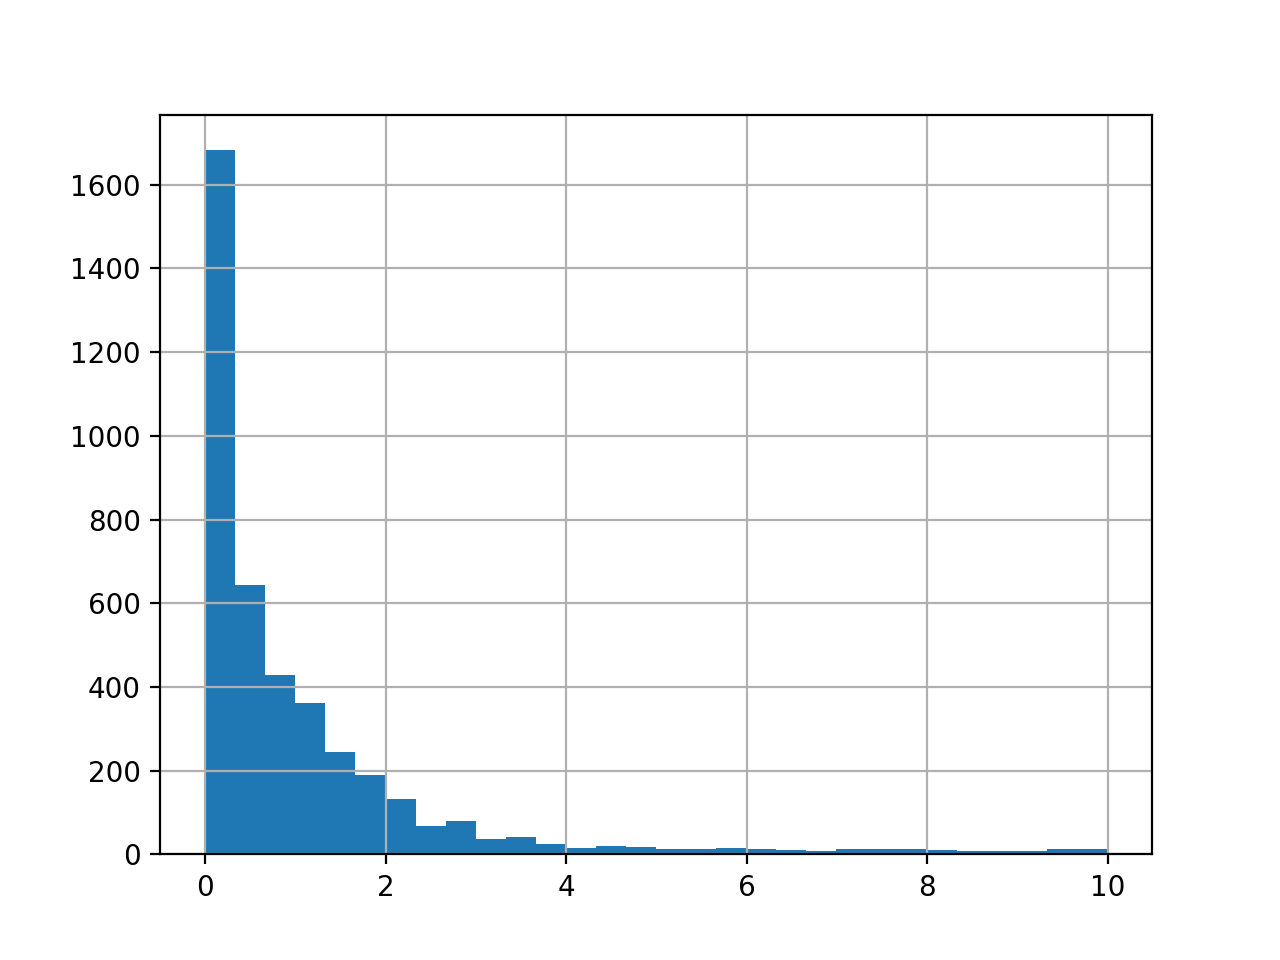

<AxesSubplot:>

In [176]:
%matplotlib notebook
nutrient_ratio_younger['Energy'].loc[:, nutrient_ratio_younger['Energy'] <= 10].hist(bins=30)
plt.axvline(x = 1, color = 'red')

In [ ]:
!pip install wbdata
import wbdata
import matplotlib.pyplot as plt
import plotly.offline as py
import plotly.graph_objs as go
import cufflinks as cf
import seaborn as sns
import matplotlib.pyplot as plt
cf.go_offline()

In [ ]:
def indicators_df(code,name):
    variable_labels = {code:name}
    NGA = wbdata.get_dataframe(variable_labels, country="NGA").sort_values('date')

    return NGA

def plot_indicators(code,name):
    world = indicators_df(code,name)

    date = np.asarray(world['date'].values, float)
    nga = world.values

    plt.figure(figsize=(14,9))
    plt.plot(date,nga)
    plt.title(name,fontweight="bold")
    plt.xlabel("Date")
    plt.ylabel("Variable")
    plt.ylim(ymin=0)

In [ ]:
code = "NY.GNP.PCAP.CD"
name = "GNI per capita"
world = indicators_df(code,name)
world

In [ ]:
plt.figure(figsize=(15,9))
plt.plot(world)
plt.title(name,fontweight="bold")
plt.xlabel("Date")
plt.ylabel("Variable")
plt.xticks(world.index, rotation='vertical')
plt.show()